In [ ]:
# @title Mount to Drive, then pip install SimpleElastix
from google.colab import drive
drive.mount('/content/drive')

import subprocess, sys
def pip_install(package):
    print(f"Trying to install {package} ...")
    result = subprocess.run(
        [sys.executable, "-m", "pip", "install", package],
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        text=True,
    )
    print(result.stdout)
    return result.returncode == 0

pip_install("SimpleITK-SimpleElastix")

Mounted at /content/drive
Trying to install SimpleITK-SimpleElastix ...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 MB 12.4 MB/s eta 0:00:00



True

In [ ]:
#@title Read Reference Image
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

# 1. Read the image directly
# SimpleITK automatically detects the bit depth (e.g., 16-bit signed/unsigned)
path = "/content/drive/MyDrive/Fall 2025/6127 - MSP/MSP Final Project/fixed_xrays/00000147_000.png"
image = sitk.ReadImage(path)

In [ ]:
#@title global variables - transformation parameters
# will probably be set to rand() within a reasonable range
theta = np.deg2rad(10)           # degrees
translation_x = 5.0     # normalized to image scale
translation_y = -10.0   # mm / pixels*spacing
shear_factor_x = 0.2
shear_factor_y = 0.1
# theta = np.deg2rad(0)           # degrees
# translation_x = 0.0
# translation_y = 0.0
# shear_factor_x = 0.0
# shear_factor_y = 0.0

Transformation Parameters:
  Rotation Angle (degrees): 10.00
  Translation (x, y): 5.00, -10.00
  Shear Factors (kx, ky): 0.20, 0.10


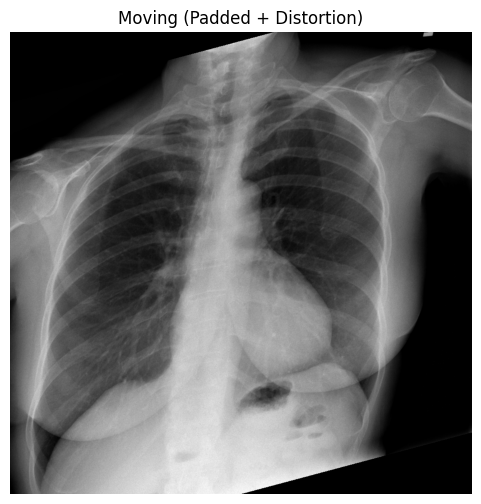

In [ ]:
#@title Pad Image, Apply Distortions
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

# ------------------------
# 1) Load & prep original image
# ------------------------
# assume `image` is your original X-ray (RGB or single-channel)

# If RGB, convert to grayscale
if image.GetNumberOfComponentsPerPixel() > 1:
    image_gray = sitk.VectorIndexSelectionCast(image, 0)
else:
    image_gray = image

# Cast to float for registration
image_float = sitk.Cast(image_gray, sitk.sitkFloat32)
# Add Poisson noise to model quantum noise and photon fluctuations
# Adjust poisson_scale_factor to control the amount of noise:
# A higher factor simulates more photons, leading to less relative noise.
poisson_scale_factor = 10 # Tune this value

# Convert SimpleITK image to numpy array for noise addition
image_array_float = sitk.GetArrayFromImage(image_float)

# Scale the image data to simulate 'photon counts' for Poisson distribution
scaled_image_for_poisson = image_array_float * poisson_scale_factor

# Apply Poisson noise and cast back to float
noisy_scaled_image_array = np.random.poisson(scaled_image_for_poisson).astype(np.float32)

# Scale back down to original intensity range
noisy_image_array = noisy_scaled_image_array / poisson_scale_factor

# Convert the numpy array back to a SimpleITK image
image_noisy = sitk.GetImageFromArray(noisy_image_array)

# Copy spatial information from original image_float to the new image_noisy
image_noisy.CopyInformation(image_float)

# Ensure the final image is float32 after conversion
image_noisy = sitk.Cast(image_noisy, sitk.sitkFloat32)

# ------------------------
# 2) Pad the image (canvas)
# ------------------------
pad_frac = 0.0  # 20% padding all around (tune this)
orig_size = image_noisy.GetSize()

pad_x = int(orig_size[0] * pad_frac)
pad_y = int(orig_size[1] * pad_frac)

fixed_padded = sitk.ConstantPad(
    image_noisy,
    padLowerBound=(pad_x, pad_y),
    padUpperBound=(pad_x, pad_y),
    constant=0.0,  # black padding
)
# set center to image center (in physical coords) for nicer behavior
size_p = fixed_padded.GetSize()
spacing_p = fixed_padded.GetSpacing()
origin_p = fixed_padded.GetOrigin()

center_phys = [
    origin_p[0] + spacing_p[0] * size_p[0] / 2.0,
    origin_p[1] + spacing_p[1] * size_p[1] / 2.0,
]
# ------------------------
# 3) Build composite transform: Euler (R+T) then Affine (shear)
# ------------------------
euler = sitk.Euler2DTransform()
euler.SetCenter(center_phys)

euler.SetAngle(theta)
euler.SetTranslation((translation_x, translation_y))

# 3b) AffineTransform for shear
affine = sitk.AffineTransform(2)
matrix_list = list(affine.GetMatrix())  # [m00, m01, m10, m11]

matrix_list[1] = shear_factor_x  # m01
matrix_list[2] = shear_factor_y  # m10
affine.SetMatrix(matrix_list)
affine.SetCenter(center_phys)

# 3c) Composite transform: apply Euler *then* shear
composite = sitk.CompositeTransform(2)
composite.AddTransform(euler)   # first rotation+translation
composite.AddTransform(affine)  # then shear

# 3d) Apply composite transform on the padded canvas
moving_padded = sitk.Resample(
    fixed_padded,               # reference grid (padded)
    composite,                  # composite transform
    sitk.sitkLinear,            # interpolator
    0.0,                        # default pixel value outside
    fixed_padded.GetPixelID(),  # output pixel type
)
def show(img, title="", ax=None):
    arr = sitk.GetArrayFromImage(img)
    if ax is None:
        plt.figure(figsize=(6,6))
        ax = plt.gca()
    ax.imshow(arr, cmap="gray")
    ax.set_title(title)
    ax.axis("off")


print(f"Transformation Parameters:\n" \
      f"  Rotation Angle (degrees): {np.rad2deg(theta):.2f}\n" \
      f"  Translation (x, y): {translation_x:.2f}, {translation_y:.2f}\n" \
      f"  Shear Factors (kx, ky): {shear_factor_x:.2f}, {shear_factor_y:.2f}")
# show(image_float, "Fixed (Original)")
# show(image_noisy,"Fixed (Noisy)")

# Create a figure with a 2x2 subplot grid
# fig, axes = plt.subplots(1, 2, figsize=(8,8))
# axes = axes.flatten() # Flatten the 2x2 array of axes for easy iteration

# show(moving_padded, "Moving (Rotation + Translation + Shear)",ax=axes[0])
# show(image_noisy-image_float,"Poisson Noise",ax=axes[1])
# plt.show()

show(moving_padded, "Moving (Padded + Distortion)")

# fixed_smooth  = sitk.DiscreteGaussian(fixed_padded, 1.2)
# moving_smooth = sitk.DiscreteGaussian(moving_padded, 1.2)


# show(fixed_smooth, "Fixed (Smoothed)")
# show(moving_smooth, "Moving (Smoothed)")
# show(moving_smooth-moving_padded,"difference, moving")

In [ ]:
#@title Run registration on padded images
print("Using ElastixImageFilter with padded fixed/moving.")
elastix = sitk.ElastixImageFilter()
# elastix.SetFixedImage(fixed_padded)
# elastix.SetMovingImage(moving_padded)

elastix.SetFixedImage(fixed_padded)
elastix.SetMovingImage(moving_padded)

# Quick MI settings
# pmap_rigid = sitk.GetDefaultParameterMap("rigid")
# pmap_rigid["Metric"] = ["AdvancedMattesMutualInformation"]
# pmap_rigid["NumberOfSpatialSamples"] = ["4000"]       # down from 12000
# pmap_rigid["MaximumNumberOfIterations"] = ["150"]     # down from 400
# pmap_rigid["NumberOfResolutions"] = ["3"]             # down from 4
# pmap_rigid["NumberOfHistogramBins"] = ["32"]          # 16–32 is fine for 2D X-rays

# pmap_rigid["AutomaticScalesEstimation"] = ["true"]
# pmap_rigid["AutomaticTransformInitialization"] = ["true"]
# pmap_rigid["AutomaticTransformInitializationMethod"] = ["GeometricalCenter"]

# pmap_affine = sitk.GetDefaultParameterMap("affine")
# pmap_affine["Metric"] = ["AdvancedMattesMutualInformation"]
# pmap_affine["NumberOfSpatialSamples"] = ["6000"]      # down from 15000
# pmap_affine["MaximumNumberOfIterations"] = ["250"]    # down from 600
# pmap_affine["NumberOfResolutions"] = ["2"]            # down from 3
# pmap_affine["AutomaticScalesEstimation"] = ["true"]

# Moderate MI settings
pmap_rigid = sitk.GetDefaultParameterMap("rigid")
pmap_rigid["Metric"] = ["AdvancedMattesMutualInformation"]
pmap_rigid["NumberOfSpatialSamples"] = ["4000"]
pmap_rigid["MaximumNumberOfIterations"] = ["200"]
pmap_rigid["NumberOfResolutions"] = ["4"]
pmap_rigid["AutomaticScalesEstimation"] = ["true"]
pmap_rigid["AutomaticTransformInitialization"] = ["true"]
pmap_rigid["AutomaticTransformInitializationMethod"] = ["GeometricalCenter"]

pmap_affine = sitk.GetDefaultParameterMap("affine")
pmap_affine["Metric"] = ["AdvancedMattesMutualInformation"]
pmap_affine["NumberOfSpatialSamples"] = ["6000"]
pmap_affine["MaximumNumberOfIterations"] = ["450"]
pmap_affine["NumberOfResolutions"] = ["3"]
pmap_affine["AutomaticScalesEstimation"] = ["true"]

pmaps = sitk.VectorOfParameterMap()
pmaps.append(pmap_rigid)
pmaps.append(pmap_affine)

elastix.SetParameterMap(pmaps)
elastix.LogToConsoleOn()
result_padded = elastix.Execute()

print("Composite image registration completed on padded canvas.")

# ------------------------
# 5) Crop registered result back to original FOV
# ------------------------
def crop_back_to_original(padded_img, pad_x, pad_y, orig_size):
    return sitk.RegionOfInterest(
        padded_img,
        size=list(orig_size),
        index=[pad_x, pad_y],
    )

result_cropped = crop_back_to_original(result_padded, pad_x, pad_y, orig_size)

Using ElastixImageFilter with padded fixed/moving.
Composite image registration completed on padded canvas.


Transformation Parameters:
  Rotation Angle (degrees): 0.00
  Translation (x, y): 0.00, 0.00
  Shear Factors (kx, ky): 0.20, 0.10


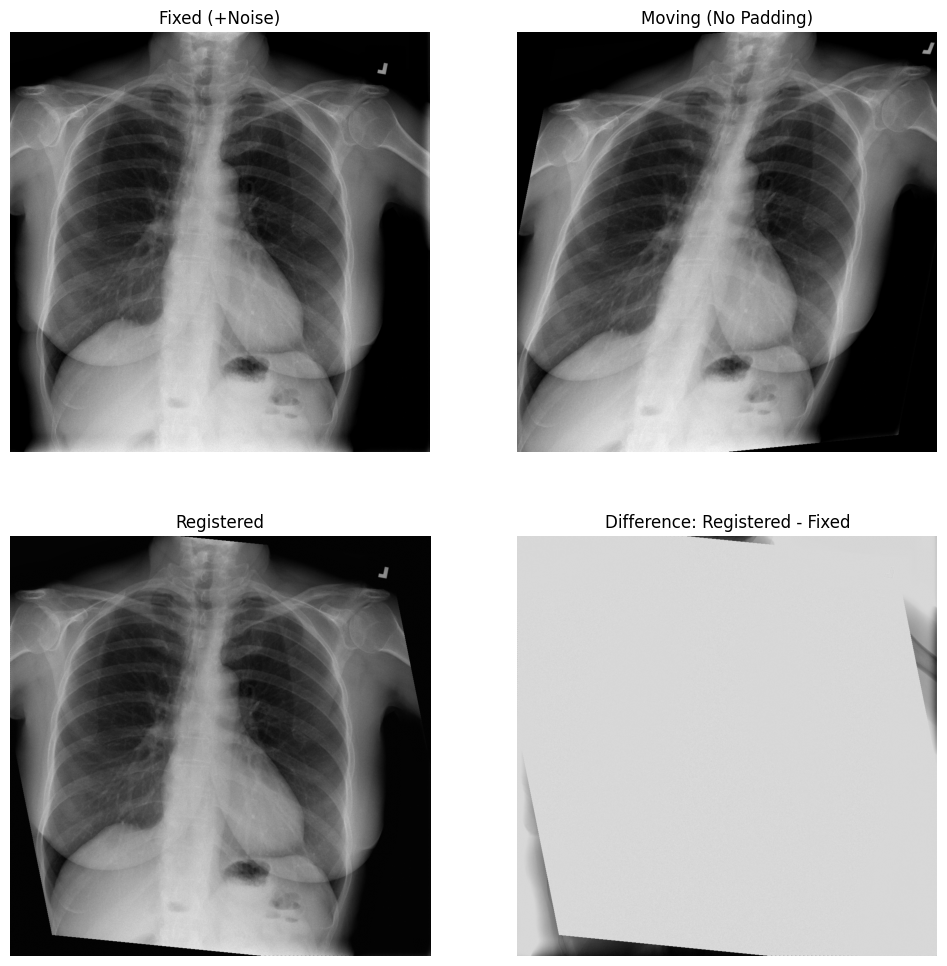

In [ ]:
#@title plots
print(f"Transformation Parameters:\n" \
      f"  Rotation Angle (degrees): {np.degrees(euler.GetAngle()):.2f}\n" \
      f"  Translation (x, y): {euler.GetTranslation()[0]:.2f}, {euler.GetTranslation()[1]:.2f}\n" \
      f"  Shear Factors (kx, ky): {shear_factor_x:.2f}, {shear_factor_y:.2f}")
# Create a figure with a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12,12))
axes = axes.flatten() # Flatten the 2x2 array of axes for easy iteration

show(image_noisy,      "Fixed (+Noise)", ax=axes[0])
show(moving_padded,    "Moving (No Padding)", ax=axes[1])
# show(result_padded,    "Registered (Padded)", ax=axes[2])
show(result_cropped,   "Registered", ax=axes[2])
show(result_cropped-image_float, "Difference: Registered - Fixed", ax=axes[3])
# plt.tight_layout()

plt.show()


In [ ]:
#@title Quantitative Results
from skimage.metrics import structural_similarity as ssim

# express image as normalized numpy array
def sitk_to_normalized_numpy(img):
    arr = sitk.GetArrayFromImage(img).astype(np.float32)

    # If the image is 3D (Z,H,W) but you know it's a single slice,
    # you can squeeze it:
    if arr.ndim == 3 and arr.shape[0] == 1:
        arr = arr[0]

    # Normalize to [0,1] to make PSNR/SSIM comparable across images
    mn, mx = arr.min(), arr.max()
    if mx > mn:
        arr = (arr - mn) / (mx - mn)
    else:
        arr = np.zeros_like(arr)
    return arr

fixed_np      = sitk_to_normalized_numpy(image_float)
registered_np = sitk_to_normalized_numpy(result_cropped)

# print(fixed_np.shape, registered_np.shape)
# assert fixed_np.shape == registered_np.shape, "Fixed and registered must have same shape."

# compute mean squared error (MSE)
def compute_mse(img1, img2):
    diff = img1 - img2
    return np.mean(diff**2)

mse = compute_mse(fixed_np, registered_np)
print("MSE:", mse)

# compute peak signal-to-noise ratio (PSNR)
# for normalized images, peak value is 1.0
def compute_psnr(img1, img2, data_range=1.0):
    mse = compute_mse(img1, img2)
    if mse == 0:
        return float("inf")
    return 10 * np.log10((data_range**2) / mse)

psnr = compute_psnr(fixed_np, registered_np, data_range=1.0)
print("PSNR (dB):", psnr)

# compute global normalized cross-correlation
def compute_ncc(img1, img2):
    x = img1.flatten() # Flatten to 1D
    y = img2.flatten()
    x_mean = x.mean()
    y_mean = y.mean()
    x_cent = x - x_mean
    y_cent = y - y_mean

    num = np.sum(x_cent * y_cent)
    den = np.sqrt(np.sum(x_cent**2) * np.sum(y_cent**2)) + 1e-12
    return num / den

ncc = compute_ncc(fixed_np, registered_np)
print("NCC:", ncc)

# compute structrual similarity using sci-kit image's
# structural_similarity() function
def compute_ssim(img1, img2):
    return ssim(img1, img2, data_range=1.0)

ssim_val = compute_ssim(fixed_np, registered_np)
print("SSIM:", ssim_val)

MSE: 0.0003242704
PSNR (dB): 34.89093
NCC: 0.9994075
SSIM: 0.8520517677774166
